![image](Logo_P6.JPG)

<h1 style = "text-align:center; color:blue;border: solid blue 3px;padding-top:15px;padding-bottom:15px;"> 1-Nettoyage_Projet 6 : Analysez les ventes d'une librairie avec R  </h1>

Lapage était originellement une librairie physique avec plusieurs points de vente. Mais devant le succès de certains de ses produits et l’engouement de ses clients, elle a décidé depuis 2 ans d’ouvrir un site de vente en ligne et il souhaite faire le point, et pouvoir analyser ses points forts, ses points faibles, les comportements clients, etc. par exemple décider s'il doit créer certaines offres, adapter certains prix, etc.

**Cette analyse va être découpée en deux parties** :

***Demande d'Antoine***, chargé de produit marketing, Une analyse des différents indicateurs de vente :

1- Les différents indicateurs et graphiques autour du chiffre d'affaires.

2- L’évolution dans le temps et mettre en place une décomposition en moyenne mobile pour évaluer la tendance globale.

3- Un zoom sur les références, pour voir un peu les tops et les flops, la répartition par catégorie, etc.

4- Informations sur les profils de nos clients, et également la répartition du chiffre d'affaires entre eux, via par exemple une courbe de Lorenz.

5- Toutes les informations et tous graphiques qui apporteraient de l’information pertinente sont les bienvenus !

***Demandes de Julie***, chargée d’études en marketing : Une analyse plus ciblée sur les clients afin de comprendre le comportement de nos clients en ligne, pour pouvoir ensuite comparer avec la connaissance acquise via nos librairies physiques :

1- Le lien entre le genre d’un client et les catégories des livres achetés.

2- Le lien entre l’âge des clients et 

A- Le montant total des achats, 

B- La fréquence d’achat, 

C- La taille du panier moyen et 

D- Les catégories des livres achetés.

In [1]:
rm(list=ls()) # On efface le cache (Pour ne pas saturer la mémoire vive Ram)

<a id="sec:librairies"></a>

---
#### *Les librairies utiles pour le projet*
---

In [4]:
library("readxl")
library(data.table)
library(dplyr)
library(stringr)
library("ggplot2")
library(tidyverse)
library("lubridate")

<a id="sec:xlsx"></a>

#### *Importation des données (csv)*
---

Il y a 3 fichiers csv à disposition : Clients, Produits et Transactions

- ##### Clients

In [5]:
Clients <- fread("RESSOURCES/customers.csv", encoding = "UTF-8")
Clients <- setDT(Clients) # on transforme les données d'entrée en data table pour faciliter le traitement
dim(Clients) #8621   3    8623    3
head(Clients,3)

[1] 8623    3

client_id,sex,birth
<chr>,<chr>,<int>
c_4410,f,1967
c_7839,f,1975
c_1699,f,1984


- ##### Produits

In [6]:
Produits <- fread("RESSOURCES/products.csv", encoding = "UTF-8")
Produits <- setDT(Produits) # on transforme les données d'entrée en data table pour faciliter le traitement
dim(Produits) # 3287 X 3
head(Produits,3)

[1] 3287    3

id_prod,price,categ
<chr>,<dbl>,<int>
0_1421,19.99,0
0_1368,5.13,0
0_731,17.99,0


- ##### Transactions

In [7]:
Transactions <- fread("RESSOURCES/transactions.csv", encoding = "UTF-8")
Transactions <- setDT(Transactions) # on transforme les données d'entrée en data table pour faciliter le traitement
dim(Transactions) # 679532 X 4
head(Transactions,3)

[1] 679532      4

id_prod,date,session_id,client_id
<chr>,<chr>,<chr>,<chr>
0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714


<a id="sec:Détecter"></a>

### 1. Détecter les erreurs
---

<a id="sec:type"></a>

#### *Erreurs de type*
---

Le premier reflexe devrait être de vérifier que les variables ont bien été importées dans le bon type :

- ##### Clients

In [7]:
str(Clients)

Classes ‘data.table’ and 'data.frame':	8623 obs. of  3 variables:
 $ client_id: chr  "c_4410" "c_7839" "c_1699" "c_5961" ...
 $ sex      : chr  "f" "f" "f" "f" ...
 $ birth    : int  1967 1975 1984 1962 1943 1993 1967 1978 1971 1993 ...
 - attr(*, ".internal.selfref")=<externalptr> 


- ##### Produits

In [8]:
str(Produits)

Classes ‘data.table’ and 'data.frame':	3287 obs. of  3 variables:
 $ id_prod: chr  "0_1421" "0_1368" "0_731" "1_587" ...
 $ price  : num  19.99 5.13 17.99 4.99 3.99 ...
 $ categ  : int  0 0 0 1 0 0 1 0 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [9]:
Produits <- Produits[, categ:=as.character(categ)]

In [10]:
str(Produits)

Classes ‘data.table’ and 'data.frame':	3287 obs. of  3 variables:
 $ id_prod: chr  "0_1421" "0_1368" "0_731" "1_587" ...
 $ price  : num  19.99 5.13 17.99 4.99 3.99 ...
 $ categ  : chr  "0" "0" "0" "1" ...
 - attr(*, ".internal.selfref")=<externalptr> 


- ##### Transactions

In [11]:
str(Transactions)

Classes ‘data.table’ and 'data.frame':	679532 obs. of  4 variables:
 $ id_prod   : chr  "0_1518" "1_251" "0_1277" "2_209" ...
 $ date      : chr  "2022-05-20 13:21:29.043970" "2022-02-02 07:55:19.149409" "2022-06-18 15:44:33.155329" "2021-06-24 04:19:29.835891" ...
 $ session_id: chr  "s_211425" "s_158752" "s_225667" "s_52962" ...
 $ client_id : chr  "c_103" "c_8534" "c_6714" "c_6941" ...
 - attr(*, ".internal.selfref")=<externalptr> 


<a id="sec:NA"></a>

---
#### *Valeurs manquantes*
---

- ##### Clients

In [12]:
valeurs_manquantes <- function(arg_float) {
    sapply(arg_float, function(y) sum(is.na(y)))          
}

valeurs_manquantes_real <- function(arg_float, arg_string) { 
    nb_na = sapply(arg_float, function(y) sum(is.na(y)))#Valeurs manquantes
    nb_na = nb_na[nb_na>0]
    View(nb_na)
    sprintf("Le nombre total de valeurs manques dans %s est : %d.", arg_string, sum(nb_na))
} 

In [13]:
valeurs_manquantes(Clients)
valeurs_manquantes_real(Clients,"Clients")

client_id       sex     birth 
        0         0         0

named integer(0)

[1] "Le nombre total de valeurs manques dans Clients est : 0."

- ##### Produits

In [14]:
valeurs_manquantes(Produits)
valeurs_manquantes_real(Produits,"Produits") #Produits

id_prod   price   categ 
      0       0       0

named integer(0)

[1] "Le nombre total de valeurs manques dans Produits est : 0."

- ##### Transactions

In [15]:
valeurs_manquantes(Transactions)
valeurs_manquantes_real(Transactions,"Transactions") #Transactions

id_prod       date session_id  client_id 
         0          0          0          0

named integer(0)

[1] "Le nombre total de valeurs manques dans Transactions est : 0."

<a id="sec:Doublons"></a>

---
#### *Doublons*
---

- ##### Clients

In [16]:
print(paste("Le nombre total de valeurs doublons dans la variable client_id de Clients est :", 
            sum(duplicated(Clients$client_id)),".")) #Valeurs Doublons

[1] "Le nombre total de valeurs doublons dans la variable client_id de Clients est : 0 ."


- ##### Produits

In [17]:
print(paste("Le nombre total de valeurs doublons dans la variable id_prod de Produits est :", 
            sum(duplicated(Produits$id_prod)),".")) #Valeurs Doublons

[1] "Le nombre total de valeurs doublons dans la variable id_prod de Produits est : 0 ."


<a id="sec:Fusionner"></a>

---
### 2. Fusionner les données
---



#### 1er : Fusionner les deux tableaux Clients et Transactions par variable : client_id

In [18]:
Transactions_Clients <- merge(Clients,Transactions,by="client_id",all = T)
dim(Transactions_Clients) #679553 X  6
head(Transactions_Clients,3)

[1] 679553      6

client_id,sex,birth,id_prod,date,session_id
<chr>,<chr>,<int>,<chr>,<chr>,<chr>
c_1,m,1955,0_1470,2021-06-11 21:02:39.382765,s_47346
c_1,m,1955,0_1429,2021-10-15 11:28:24.523566,s_105105
c_1,m,1955,1_364,2021-12-15 23:32:41.632729,s_134971


- #### 2eme : Fusionner (Transactions_Clients & web)

2eme: Fusionner les deux tableaux Transactions_Clients et Produits par variable : id_prod

In [19]:
Transactions_Produits_Clients <- merge(Produits,Transactions_Clients, by="id_prod",all = T)
dim(Transactions_Produits_Clients) #679553  X  8
head(Transactions_Produits_Clients,3)

[1] 679574      8

id_prod,price,categ,client_id,sex,birth,date,session_id
<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
NA,NA,NA,c_1223,m,1963,NA,NA
NA,NA,NA,c_2706,f,1967,NA,NA
NA,NA,NA,c_3017,f,1992,NA,NA


### 1. Détecter les erreurs
---

#### *Valeurs manquantes*
---

In [20]:
valeurs_manquantes(Transactions_Produits_Clients)
valeurs_manquantes_real(Transactions_Produits_Clients,"Transactions_Produits_Clients") # 547 NA

id_prod      price      categ  client_id        sex      birth       date 
        21        242        242         21         21         21         42 
session_id 
        42

id_prod      price      categ  client_id        sex      birth       date 
        21        242        242         21         21         21         42 
session_id 
        42

[1] "Le nombre total de valeurs manques dans Transactions_Produits_Clients est : 652."

In [21]:
# converting a frequency table for missing 
# values to dataframe 
freq_Transactions_Produits_Clients <- data.frame(table(is.na(Transactions_Produits_Clients)))
freq_Transactions_Produits_Clients  

Var1,Freq
<fct>,<int>
FALSE,5435940
TRUE,652


#### *Valeurs <0*

In [22]:
Transactions_Produits_Clients_price_0 <-Transactions_Produits_Clients[Transactions_Produits_Clients$price < 0,]
dim(Transactions_Produits_Clients_price_0) #200  X 8
head(Transactions_Produits_Clients_price_0,3)

[1] 200   8

id_prod,price,categ,client_id,sex,birth,date,session_id
<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
T_0,-1,0,ct_0,f,2001,test_2021-03-01 02:30:02.237419,s_0
T_0,-1,0,ct_0,f,2001,test_2021-03-01 02:30:02.237425,s_0
T_0,-1,0,ct_0,f,2001,test_2021-03-01 02:30:02.237436,s_0


<a id="sec:sans_NA"></a>


#### ***Supprimer des valeurs <0***
---

In [23]:
dim(Transactions_Produits_Clients) #679553 X 8    679574
Transactions_Produits_Clients <- Transactions_Produits_Clients[Transactions_Produits_Clients$id_prod !="T_0",]
dim(Transactions_Produits_Clients) #679353 X 8

[1] 679574      8

[1] 679353      8


#### ***Remplacer les valeurs manquantes***
---

In [24]:
valeurs_manquantes(Transactions_Produits_Clients)
valeurs_manquantes_real(Transactions_Produits_Clients,"Transactions_Produits_Clients") # 547

id_prod      price      categ  client_id        sex      birth       date 
         0        221        221         21         21         21         21 
session_id 
        21

price      categ  client_id        sex      birth       date session_id 
       221        221         21         21         21         21         21

[1] "Le nombre total de valeurs manques dans Transactions_Produits_Clients est : 547."

In [25]:
NA_price_Transactions_Produits_Clients <- Transactions_Produits_Clients[is.na(Transactions_Produits_Clients$price),]
dim(NA_price_Transactions_Produits_Clients) #221    8
head(NA_price_Transactions_Produits_Clients)

[1] 221   8

id_prod,price,categ,client_id,sex,birth,date,session_id
<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
0_2245,NA,NA,c_1025,m,1984,2022-07-29 04:29:29.995701,s_245285
0_2245,NA,NA,c_1025,m,1984,2021-03-29 04:29:29.995701,s_12938
0_2245,NA,NA,c_1025,m,1984,2022-07-29 02:10:32.403467,s_245233
0_2245,NA,NA,c_1025,m,1984,2021-03-29 02:10:32.403467,s_12886
0_2245,NA,NA,c_1060,f,1973,2022-10-06 14:03:40.171938,s_278588
0_2245,NA,NA,c_1060,f,1973,2021-09-06 14:03:40.171938,s_85877


In [26]:
Transactions_Produits_Clients_categ_0<-Transactions_Produits_Clients[Transactions_Produits_Clients$categ == '0',]
summary(Transactions_Produits_Clients_categ_0$price)
Moyenne_prix_0 <- mean(Transactions_Produits_Clients_categ_0$price)
Moyenne_prix_0

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.62    6.29    9.99   10.64   14.45   40.99 

[1] 10.63833

In [27]:
Transactions_Produits_Clients[is.na(categ) & id_prod == "0_2245",categ:="0"]
Transactions_Produits_Clients[categ=="0" & id_prod == "0_2245",price:=Moyenne_prix_0] #10.63
head(Transactions_Produits_Clients[Transactions_Produits_Clients$id_prod == '0_2245',])


id_prod,price,categ,client_id,sex,birth,date,session_id
<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
0_2245,10.63833,0,c_1025,m,1984,2022-07-29 04:29:29.995701,s_245285
0_2245,10.63833,0,c_1025,m,1984,2021-03-29 04:29:29.995701,s_12938
0_2245,10.63833,0,c_1025,m,1984,2022-07-29 02:10:32.403467,s_245233
0_2245,10.63833,0,c_1025,m,1984,2021-03-29 02:10:32.403467,s_12886
0_2245,10.63833,0,c_1060,f,1973,2022-10-06 14:03:40.171938,s_278588
0_2245,10.63833,0,c_1060,f,1973,2021-09-06 14:03:40.171938,s_85877


#### ***Supprimer des valeurs NA***
---

In [28]:
valeurs_manquantes(Transactions_Produits_Clients)
valeurs_manquantes_real(Transactions_Produits_Clients,"Transactions_Produits_Clients") # 105

id_prod      price      categ  client_id        sex      birth       date 
         0          0          0         21         21         21         21 
session_id 
        21

client_id        sex      birth       date session_id 
        21         21         21         21         21

[1] "Le nombre total de valeurs manques dans Transactions_Produits_Clients est : 105."

In [29]:
NA_date_Transactions_Produits_Clients <- Transactions_Produits_Clients[is.na(Transactions_Produits_Clients$client_id),]
dim(NA_date_Transactions_Produits_Clients) # 21  X  8
dim(Transactions_Produits_Clients)# 679353  X  8
head(NA_date_Transactions_Produits_Clients,3)

[1] 21  8

[1] 679353      8

id_prod,price,categ,client_id,sex,birth,date,session_id
<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
0_1014,1.15,0,NA,NA,NA,NA,NA
0_1016,35.06,0,NA,NA,NA,NA,NA
0_1025,24.99,0,NA,NA,NA,NA,NA


In [30]:
Transactions_Produits_Clients <- Transactions_Produits_Clients[!is.na(Transactions_Produits_Clients$client_id),]
dim(Transactions_Produits_Clients) #679332  x  8

[1] 679332      8

In [31]:
valeurs_manquantes(Transactions_Produits_Clients)
valeurs_manquantes_real(Transactions_Produits_Clients,"Transactions_Produits_Clients") # 0 NA

id_prod      price      categ  client_id        sex      birth       date 
         0          0          0          0          0          0          0 
session_id 
         0

named integer(0)

[1] "Le nombre total de valeurs manques dans Transactions_Produits_Clients est : 0."

### ***Les Séries temporelles et représentation graphique***

In [32]:
Transactions_Produits_Clients[,minute:=substr(date,1,16)]
Transactions_Produits_Clients[,heure:=substr(date,1,13)]
Transactions_Produits_Clients[,jour:=substr(date,1,10)]
Transactions_Produits_Clients$jour = as.Date(Transactions_Produits_Clients$jour , "%Y-%m-%d")
Transactions_Produits_Clients[,mois:=substr(date,1,7)]
Transactions_Produits_Clients[,year:=substr(date,1,4)]
head(Transactions_Produits_Clients,3)

id_prod,price,categ,client_id,sex,birth,date,session_id,minute,heure,jour,mois,year
<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<date>,<chr>,<chr>
0_0,3.75,0,c_1004,m,1973,2021-03-02 21:57:33.862118,s_908,2021-03-02 21:57,2021-03-02 21,2021-03-02,2021-03,2021
0_0,3.75,0,c_1011,f,1999,2022-03-18 16:40:10.068303,s_180968,2022-03-18 16:40,2022-03-18 16,2022-03-18,2022-03,2022
0_0,3.75,0,c_1011,f,1999,2022-02-18 16:40:10.068303,s_167174,2022-02-18 16:40,2022-02-18 16,2022-02-18,2022-02,2022


In [33]:
Transactions_Produits_Clients <- Transactions_Produits_Clients[, categ:=as.character(categ)]

In [34]:
str(Transactions_Produits_Clients)

Classes ‘data.table’ and 'data.frame':	679332 obs. of  13 variables:
 $ id_prod   : chr  "0_0" "0_0" "0_0" "0_0" ...
 $ price     : num  3.75 3.75 3.75 3.75 3.75 3.75 3.75 3.75 3.75 3.75 ...
 $ categ     : chr  "0" "0" "0" "0" ...
 $ client_id : chr  "c_1004" "c_1011" "c_1011" "c_1011" ...
 $ sex       : chr  "m" "f" "f" "f" ...
 $ birth     : int  1973 1999 1999 1999 1999 1975 1975 1975 1961 1961 ...
 $ date      : chr  "2021-03-02 21:57:33.862118" "2022-03-18 16:40:10.068303" "2022-02-18 16:40:10.068303" "2022-04-18 16:40:10.068303" ...
 $ session_id: chr  "s_908" "s_180968" "s_167174" "s_195932" ...
 $ minute    : chr  "2021-03-02 21:57" "2022-03-18 16:40" "2022-02-18 16:40" "2022-04-18 16:40" ...
 $ heure     : chr  "2021-03-02 21" "2022-03-18 16" "2022-02-18 16" "2022-04-18 16" ...
 $ jour      : Date, format: "2021-03-02" "2022-03-18" ...
 $ mois      : chr  "2021-03" "2022-03" "2022-02" "2022-04" ...
 $ year      : chr  "2021" "2022" "2022" "2022" ...
 - attr(*, ".internal.selfr

`summarise()` has grouped output by 'jour'. You can override using the
`.groups` argument.


[1] "Le nombre total de jours de vente de catégorie 0 est : 730 ."
[1] "Le nombre total de jours de vente de catégorie 1 est : 704 ."
[1] "Le nombre total de jours de vente de catégorie 2 est : 730 ."


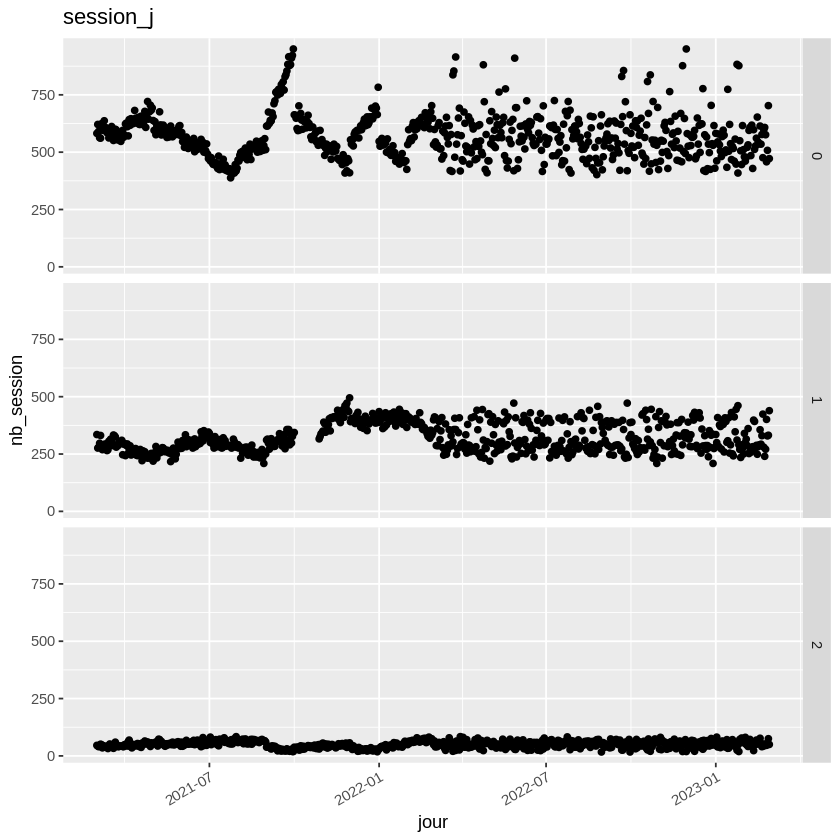

In [35]:
# jour
session_j <- Transactions_Produits_Clients %>% 
      group_by(jour,categ) %>% 
      dplyr::summarise(nb_session = n())
    #print(dim(session_j))
#head(session_j)

session_j_0<-session_j[session_j$categ == '0',]
session_j_1<-session_j[session_j$categ == '1',]
session_j_2<-session_j[session_j$categ == '2',]

print(paste("Le nombre total de jours de vente de catégorie 0 est :", format(dim(session_j_0)[1]), "."))
print(paste("Le nombre total de jours de vente de catégorie 1 est :", format(dim(session_j_1)[1]), "."))
print(paste("Le nombre total de jours de vente de catégorie 2 est :", format(dim(session_j_2)[1]), "."))

plot_session_j <- ggplot(session_j, aes(jour, nb_session, group = 1)) +
         geom_point() +
         #geom_line() +
theme(axis.text.x = element_text(angle=30, hjust=1))+
         labs(x = "jour", y = "nb_session", 
              title = "session_j")
plot_session_j + facet_grid(categ ~ .)

`summarise()` has grouped output by 'jour'. You can override using the
`.groups` argument.


[1] "Le nombre de jours de vente de catégorie 0 de septembre à novembre 2021 est : 91 ."
[1] "Le nombre de jours de vente de catégorie 1 de septembre à novembre 2021 est : 65 ."
[1] "Le nombre de jours de vente de catégorie 2 de septembre à novembre 2021 est : 91 ."


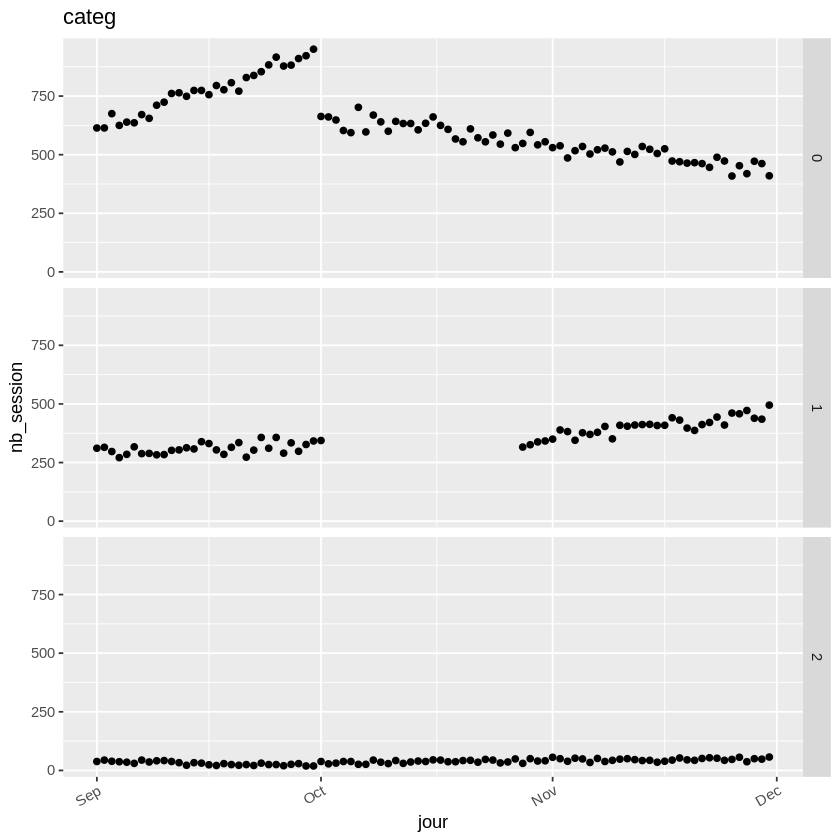

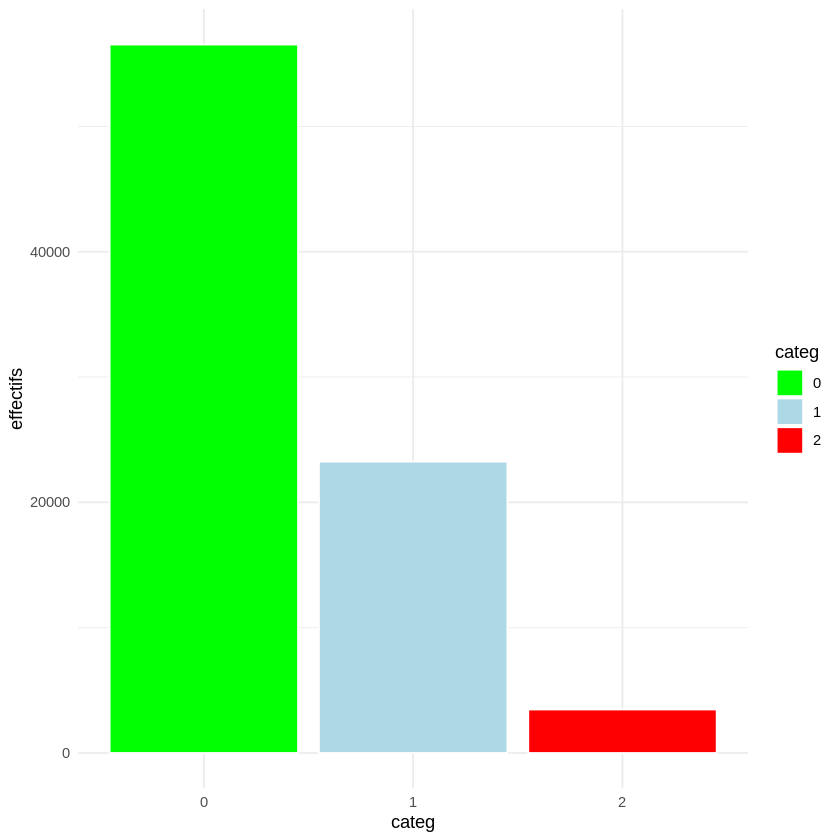

In [36]:
# 09 & 10 & 11_2021 jour categ

Transactions_Produits_Clients_9_11_2021 <- Transactions_Produits_Clients[mois == "2021-09" | mois =="2021-10"|mois =="2021-11",]

session_jour_9_11_2021 <- Transactions_Produits_Clients_9_11_2021 %>% 
      group_by(jour,categ) %>% 
      dplyr::summarise(nb_session = n())

session_jour_9_11_2021_0<-session_jour_9_11_2021[session_jour_9_11_2021$categ == '0',]
session_jour_9_11_2021_1<-session_jour_9_11_2021[session_jour_9_11_2021$categ == '1',]
session_jour_9_11_2021_2<-session_jour_9_11_2021[session_jour_9_11_2021$categ == '2',]

print(paste("Le nombre de jours de vente de catégorie 0 de septembre à novembre 2021 est :", format(dim(session_jour_9_11_2021_0)[1]), "."))
print(paste("Le nombre de jours de vente de catégorie 1 de septembre à novembre 2021 est :", format(dim(session_jour_9_11_2021_1)[1]), "."))
print(paste("Le nombre de jours de vente de catégorie 2 de septembre à novembre 2021 est :", format(dim(session_jour_9_11_2021_2)[1]), "."))


plot_session_jour_9_11_2021 <- ggplot(session_jour_9_11_2021, aes(jour, nb_session, group = 1)) +
  geom_point() +
 #geom_line() +
  theme(axis.text.x = element_text(angle=30, hjust=1))+
  labs(x = "jour", y = "nb_session", 
       title = "categ")
plot_session_jour_9_11_2021 + facet_grid(categ ~ .)

Trou_10_2021 <- Transactions_Produits_Clients[jour>="2021-10-02" & jour<="2021-10-27",]
#dim(Trou_10_2021)
# print(paste("Le nombre de jours de vente de catégorie 0 au mois d'octobre 2021 est :", format(dim(Trou_10_2021)[1]), "."))

#head(Trou_10_2021)

# VARIABLE QUALITATIVE
value_counts = as.data.frame(table(Transactions_Produits_Clients_9_11_2021$categ))
colnames(value_counts) = c("categ","effectifs")

# Diagramme en tuyaux d'orgues
ggplot(value_counts, aes(x=categ, y=effectifs, fill=categ))+
geom_bar(stat="identity", color="white")+
scale_fill_manual(values=c("green", "lightblue", "red"))+
  theme_minimal()

`summarise()` has grouped output by 'jour'. You can override using the
`.groups` argument.


[1] "Le nombre de jours de vente de catégorie 0 au mois d'octobre 2021 est : 31 ."
[1] "Le nombre de jours de vente de catégorie 1 au mois d'octobre 2021 est : 5 ."
[1] "Le nombre de jours de vente de catégorie 2 au mois d'octobre 2021 est : 31 ."


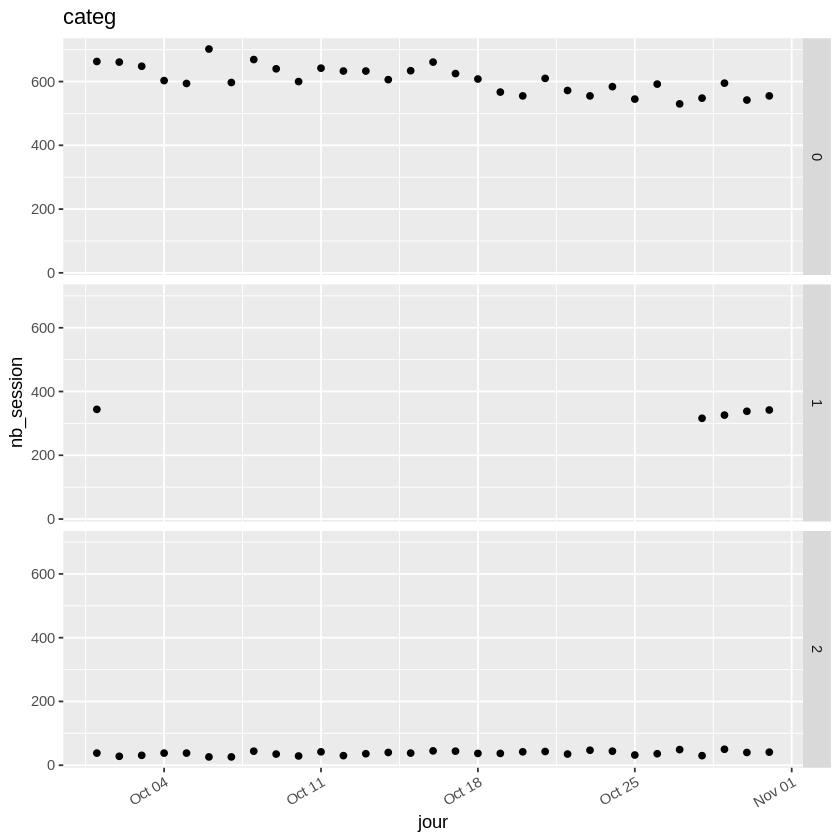

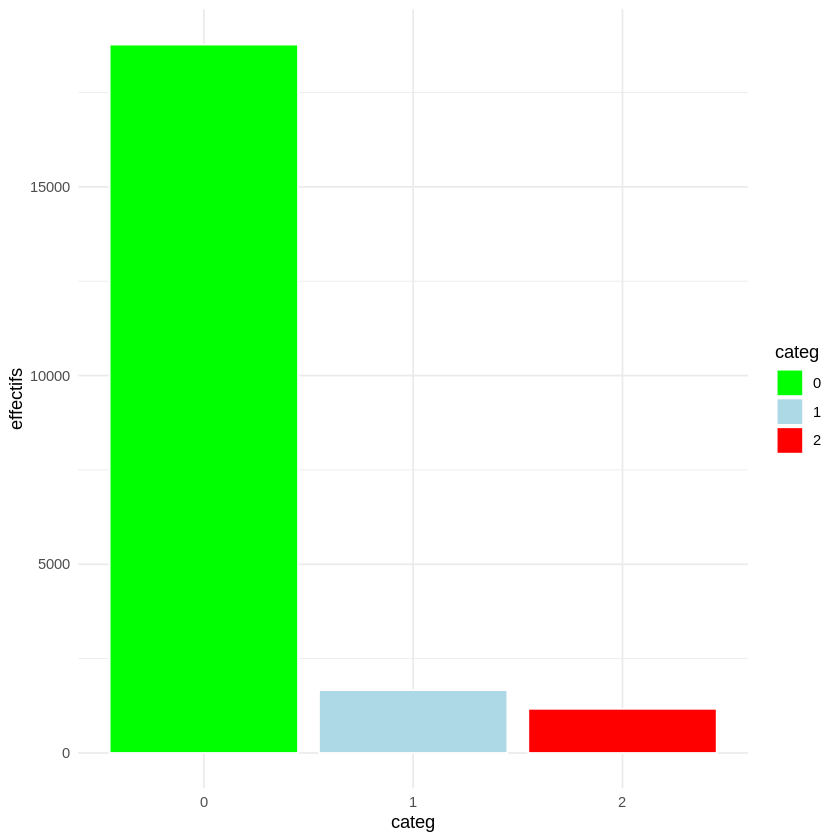

In [37]:
# 10_2021 jour categ

Transactions_Produits_Clients_10_2021 <- Transactions_Produits_Clients[mois=="2021-10",] 
#head(Transactions_Produits_Clients_10_2021)

session_jour_10_2021 <- Transactions_Produits_Clients_10_2021 %>% 
      group_by(jour,categ) %>% 
      dplyr::summarise(nb_session = n())

session_jour_10_2021_0<-session_jour_10_2021[session_jour_10_2021$categ == '0',]
session_jour_10_2021_1<-session_jour_10_2021[session_jour_10_2021$categ == '1',]
session_jour_10_2021_2<-session_jour_10_2021[session_jour_10_2021$categ == '2',]

print(paste("Le nombre de jours de vente de catégorie 0 au mois d'octobre 2021 est :", format(dim(session_jour_10_2021_0)[1]), "."))
print(paste("Le nombre de jours de vente de catégorie 1 au mois d'octobre 2021 est :", format(dim(session_jour_10_2021_1)[1]), "."))
print(paste("Le nombre de jours de vente de catégorie 2 au mois d'octobre 2021 est :", format(dim(session_jour_10_2021_2)[1]), "."))
# session_jour_10_2021_1
#session_jour_10_2021

plot_session_jour_10_2021 <- ggplot(session_jour_10_2021, aes(jour, nb_session, group = 1)) +
  geom_point() +
 #geom_line() +
  theme(axis.text.x = element_text(angle=30, hjust=1))+
  labs(x = "jour", y = "nb_session", 
       title = "categ")
plot_session_jour_10_2021 + facet_grid(categ ~ .)

Trou_10_2021 <- Transactions_Produits_Clients[jour>="2021-10-02" & jour<="2021-10-27",]
# dim(Trou_10_2021)
# print(paste("Le nombre de jours de vente de catégorie 0 au mois d'octobre 2021 est :", format(dim(session_jour_10_2021_0)[1]), "."))

#head(Trou_10_2021)

# VARIABLE QUALITATIVE
value_counts = as.data.frame(table(Transactions_Produits_Clients_10_2021$categ))
colnames(value_counts) = c("categ","effectifs")

# Diagramme en tuyaux d'orgues
ggplot(value_counts, aes(x=categ, y=effectifs, fill=categ))+
geom_bar(stat="identity", color="white")+
scale_fill_manual(values=c("green", "lightblue", "red"))+
  theme_minimal()

In [38]:
Transactions_Produits_Clients_categ_1<-Transactions_Produits_Clients[Transactions_Produits_Clients$categ == '1',]
head(Transactions_Produits_Clients_categ_1)


id_prod,price,categ,client_id,sex,birth,date,session_id,minute,heure,jour,mois,year
<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<date>,<chr>,<chr>
1_1,42.99,1,c_1609,m,1980,2023-02-28 10:48:01.948941,s_348182,2023-02-28 10:48,2023-02-28 10,2023-02-28,2023-02,2023
1_1,42.99,1,c_1609,m,1980,2021-11-28 10:48:01.948941,s_126295,2021-11-28 10:48,2021-11-28 10,2021-11-28,2021-11,2021
1_1,42.99,1,c_2409,f,1978,2021-07-29 02:23:40.640281,s_68471,2021-07-29 02:23,2021-07-29 02,2021-07-29,2021-07,2021
1_1,42.99,1,c_2409,f,1978,2022-06-29 02:23:40.640281,s_230808,2022-06-29 02:23,2022-06-29 02,2022-06-29,2022-06,2022
1_1,42.99,1,c_2409,f,1978,2023-01-29 02:23:40.640281,s_333868,2023-01-29 02:23,2023-01-29 02,2023-01-29,2023-01,2023
1_1,42.99,1,c_2975,f,1992,2021-07-07 19:45:56.961641,s_59212,2021-07-07 19:45,2021-07-07 19,2021-07-07,2021-07,2021


In [39]:
Trou_10_2021_1 <- Transactions_Produits_Clients_categ_1[jour>="2021-10-02" & jour<="2021-10-27",]
head(Trou_10_2021_1)

id_prod,price,categ,client_id,sex,birth,date,session_id,minute,heure,jour,mois,year
<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<date>,<chr>,<chr>


In [40]:
comp_1 <- Transactions_Produits_Clients_categ_1[jour>="2021-09-19" & jour<="2021-10-01",]
dim(comp_1)
head(comp_1)

[1] 4186   13

id_prod,price,categ,client_id,sex,birth,date,session_id,minute,heure,jour,mois,year
<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<date>,<chr>,<chr>
1_10,78.83,1,c_4594,m,1951,2021-09-29 10:35:08.570290,s_97368,2021-09-29 10:35,2021-09-29 10,2021-09-29,2021-09,2021
1_10,78.83,1,c_5894,m,1975,2021-09-19 16:49:44.618286,s_92344,2021-09-19 16:49,2021-09-19 16,2021-09-19,2021-09,2021
1_10,78.83,1,c_8502,f,1975,2021-09-23 21:57:16.154567,s_94457,2021-09-23 21:57,2021-09-23 21,2021-09-23,2021-09,2021
1_100,15.13,1,c_233,m,2004,2021-10-01 08:19:20.139763,s_98314,2021-10-01 08:19,2021-10-01 08,2021-10-01,2021-10,2021
1_100,15.13,1,c_3285,m,1989,2021-10-01 18:06:12.971592,s_98522,2021-10-01 18:06,2021-10-01 18,2021-10-01,2021-10,2021
1_100,15.13,1,c_356,m,1983,2021-09-27 03:19:46.994811,s_96119,2021-09-27 03:19,2021-09-27 03,2021-09-27,2021-09,2021


In [41]:
comp_2 <- Transactions_Produits_Clients_categ_1[jour>="2021-10-28" & jour<="2021-11-10",]
dim(comp_2)
head(comp_2)

[1] 5078   13

id_prod,price,categ,client_id,sex,birth,date,session_id,minute,heure,jour,mois,year
<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<date>,<chr>,<chr>
1_10,78.83,1,c_5997,f,1968,2021-11-02 16:57:09.030527,s_113777,2021-11-02 16:57,2021-11-02 16,2021-11-02,2021-11,2021
1_100,15.13,1,c_3268,m,1963,2021-11-09 11:39:37.651011,s_117040,2021-11-09 11:39,2021-11-09 11,2021-11-09,2021-11,2021
1_100,15.13,1,c_4389,m,1984,2021-10-29 21:39:02.389356,s_111983,2021-10-29 21:39,2021-10-29 21,2021-10-29,2021-10,2021
1_100,15.13,1,c_5782,f,1975,2021-11-02 13:18:50.551803,s_113715,2021-11-02 13:18,2021-11-02 13,2021-11-02,2021-11,2021
1_100,15.13,1,c_5920,f,1966,2021-10-28 12:30:41.500950,s_111329,2021-10-28 12:30,2021-10-28 12,2021-10-28,2021-10,2021
1_100,15.13,1,c_6259,m,1991,2021-10-31 23:12:18.324853,s_112940,2021-10-31 23:12,2021-10-31 23,2021-10-31,2021-10,2021


`summarise()` has grouped output by 'jour'. You can override using the
`.groups` argument.


[1] "Le nombre de jours de vente de catégorie 0 au mois de septembre 2021 est : 30 ."
[1] "Le nombre de jours de vente de catégorie 1 au mois de septembre 2021 est : 30 ."
[1] "Le nombre de jours de vente de catégorie 2 au mois de septembre 2021 est : 30 ."


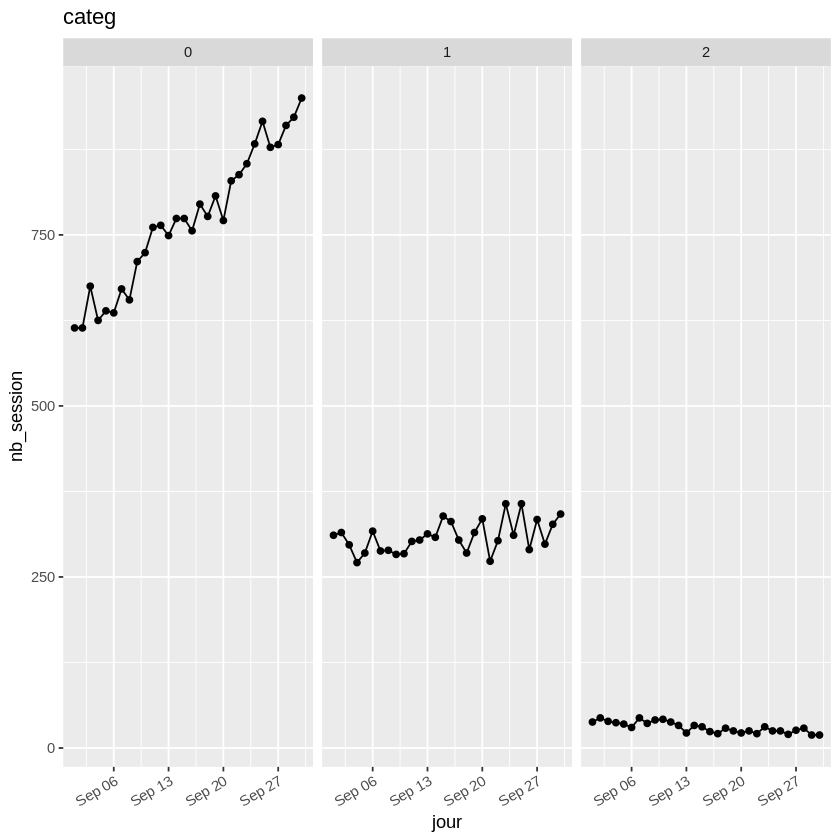

In [43]:
# 09_2021 jour categ

Transactions_Produits_Clients_09_2021 <- Transactions_Produits_Clients[mois=="2021-09",]
#head(Transactions_Produits_Clients_09_2021)

session_jour_09_2021 <- Transactions_Produits_Clients_09_2021 %>% 
  group_by(jour,categ) %>% 
  dplyr::summarise(nb_session = n())

session_jour_09_2021_0<-session_jour_09_2021[session_jour_09_2021$categ == '0',]
session_jour_09_2021_1<-session_jour_09_2021[session_jour_09_2021$categ == '1',]
session_jour_09_2021_2<-session_jour_09_2021[session_jour_09_2021$categ == '2',]

print(paste("Le nombre de jours de vente de catégorie 0 au mois de septembre 2021 est :", format(dim(session_jour_09_2021_0)[1]), "."))
print(paste("Le nombre de jours de vente de catégorie 1 au mois de septembre 2021 est :", format(dim(session_jour_09_2021_1)[1]), "."))
print(paste("Le nombre de jours de vente de catégorie 2 au mois de septembre 2021 est :", format(dim(session_jour_09_2021_2)[1]), "."))

plot_session_jour_09_2021 <- ggplot(session_jour_09_2021, aes(jour, nb_session, group = 1)) +
  geom_point() +
 geom_line() +
  theme(axis.text.x = element_text(angle=30, hjust=1))+
  labs(x = "jour", y = "nb_session", 
       title = "categ")
plot_session_jour_09_2021 + facet_grid(. ~ categ)

`summarise()` has grouped output by 'jour'. You can override using the
`.groups` argument.


[1] "Le nombre de jours de vente de catégorie 0 au mois de novembre 2021 est : 30 ."
[1] "Le nombre de jours de vente de catégorie 1 au mois de novembre 2021 est : 30 ."
[1] "Le nombre de jours de vente de catégorie 2 au mois de novembre 2021 est : 30 ."


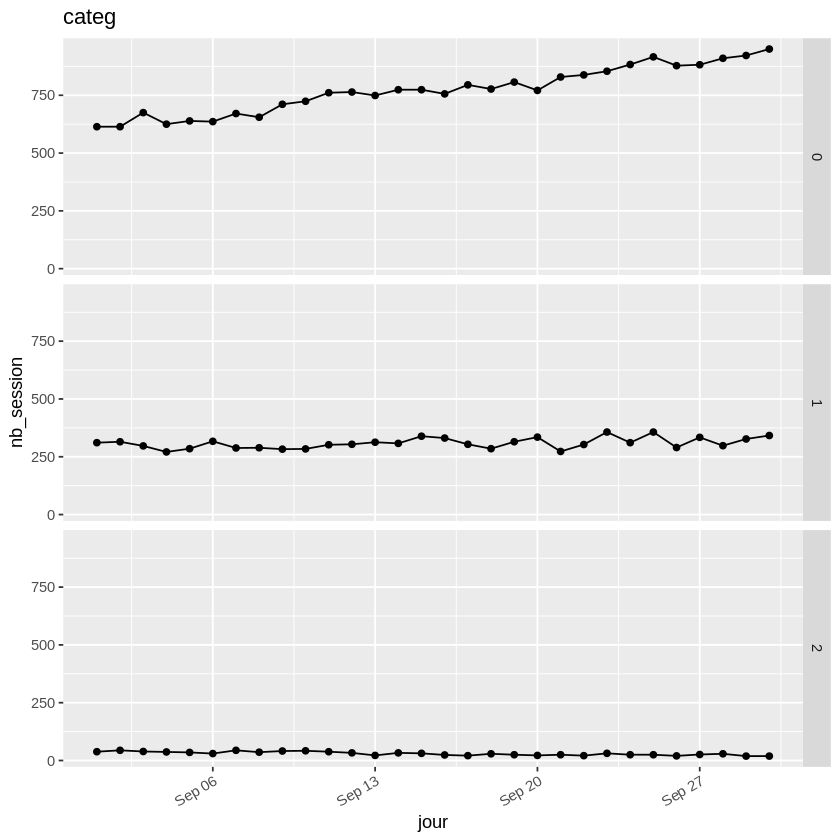

In [44]:
# 11_2021 jour categ

Transactions_Produits_Clients_11_2021 <- Transactions_Produits_Clients[mois=="2021-11",]
#head(Transactions_Produits_Clients_11_2021)

session_jour_11_2021 <- Transactions_Produits_Clients_11_2021 %>% 
  group_by(jour,categ) %>% 
  dplyr::summarise(nb_session = n())

session_jour_11_2021_0<-session_jour_11_2021[session_jour_11_2021$categ == '0',]
session_jour_11_2021_1<-session_jour_11_2021[session_jour_11_2021$categ == '1',]
session_jour_11_2021_2<-session_jour_11_2021[session_jour_11_2021$categ == '2',]

print(paste("Le nombre de jours de vente de catégorie 0 au mois de novembre 2021 est :", format(dim(session_jour_11_2021_0)[1]), "."))
print(paste("Le nombre de jours de vente de catégorie 1 au mois de novembre 2021 est :", format(dim(session_jour_11_2021_1)[1]), "."))
print(paste("Le nombre de jours de vente de catégorie 2 au mois de novembre 2021 est :", format(dim(session_jour_11_2021_2)[1]), "."))

plot_session_jour_11_2021 <- ggplot(session_jour_11_2021, aes(jour, nb_session, group = 1)) +
  geom_point() +
 geom_line() +
  theme(axis.text.x = element_text(angle=30, hjust=1))+
  labs(x = "jour", y = "nb_session", 
       title = "categ")
plot_session_jour_09_2021 + facet_grid(categ ~ .)

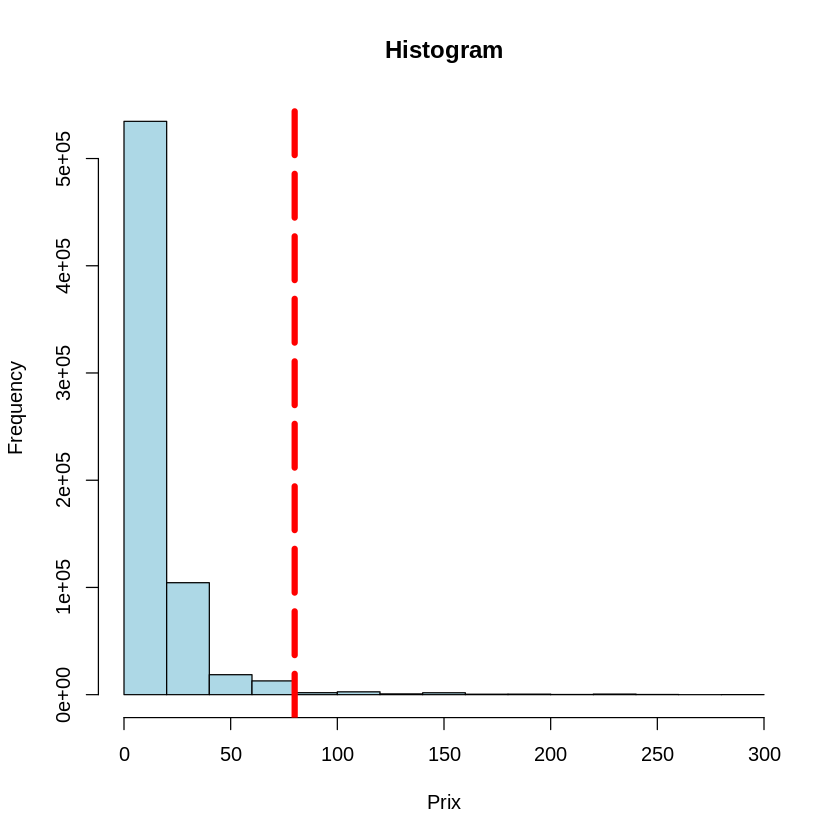

In [47]:
h = hist(Transactions_Produits_Clients$price, main="Histogram", col="lightblue", xlab="Prix")
abline(v = 80, col="red", lwd=5, lty=5)

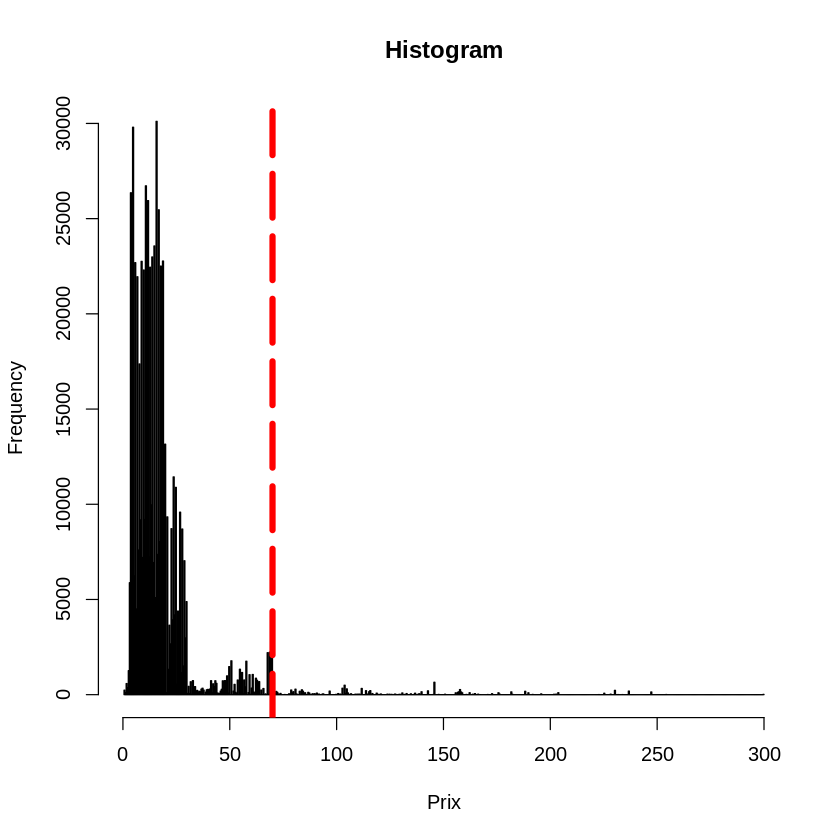

In [48]:
n_breaks <- sqrt(nrow(Transactions_Produits_Clients))
h = hist(Transactions_Produits_Clients$price, main="Histogram", col="lightblue", xlab="Prix",breaks = n_breaks)
#abline(v=80, col="red")
abline(v = 70, col="red", lwd=5, lty=5)

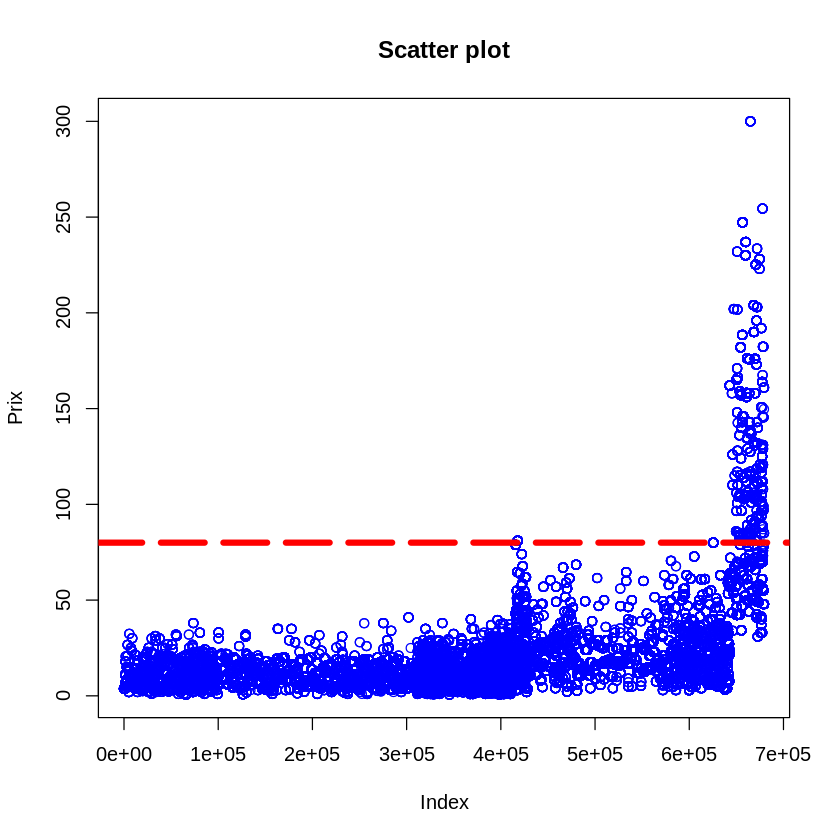

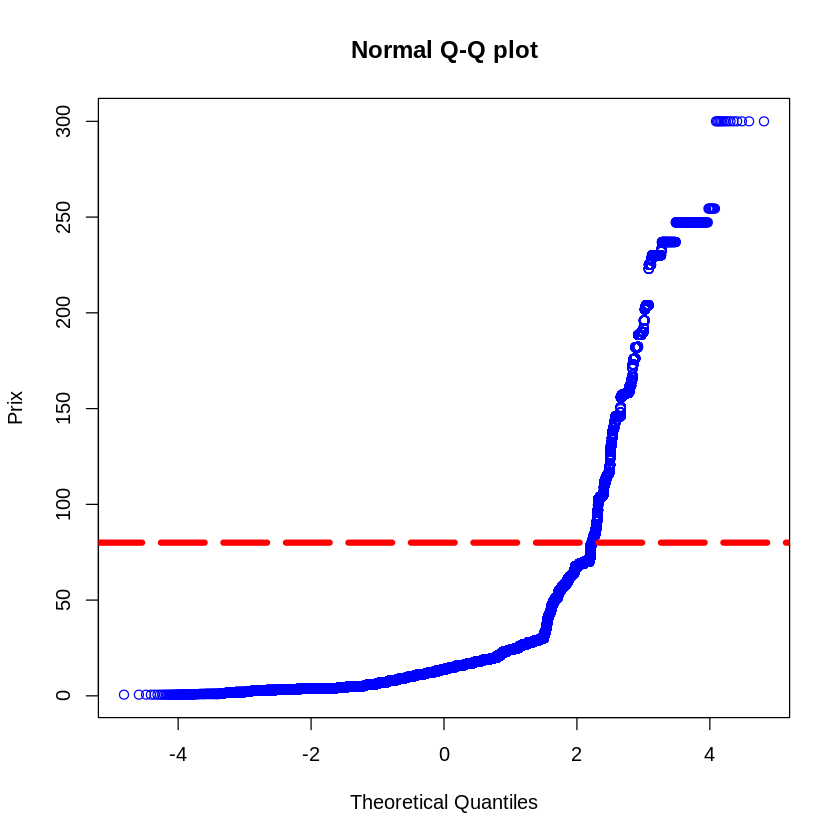

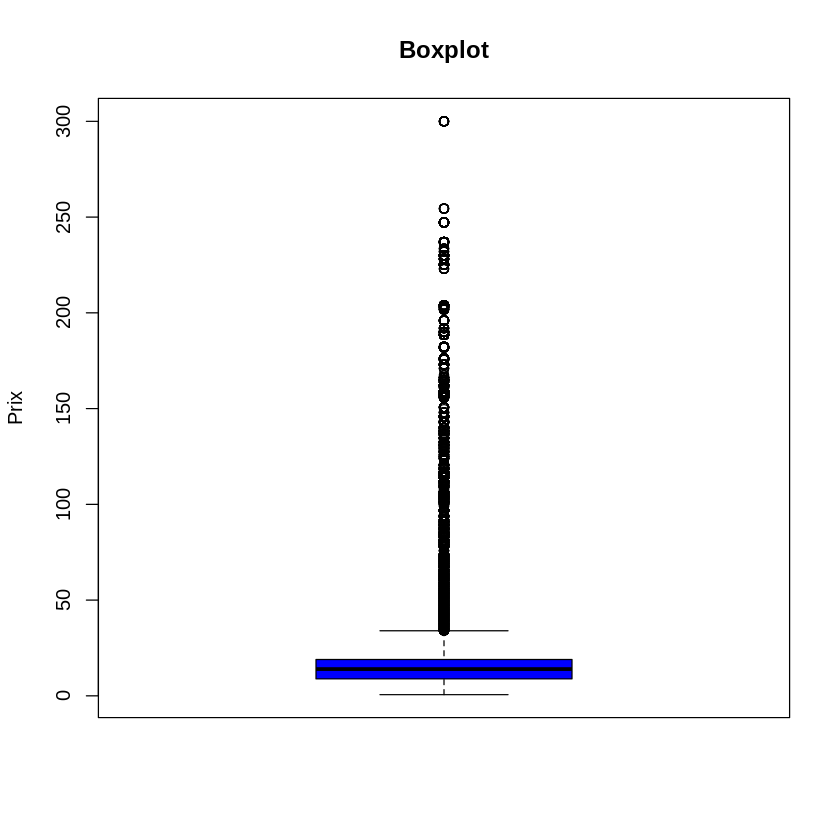

In [49]:
plot(Transactions_Produits_Clients$price, col="blue", ylab="Prix", main="Scatter plot")
#abline(h=80, col="red")
abline(h = 80, col="red", lwd=5, lty=5)
qqnorm(Transactions_Produits_Clients$price,col="blue", ylab="Prix", main = "Normal Q-Q plot")
abline(h = 80, col="red", lwd=5, lty=5)
boxplot(Transactions_Produits_Clients$price,col="blue",ylab="Prix", main = "Boxplot")
#boxplot(sans_NA_liaison_erp_web$price, main = "Boxplot horizontal", horizontal = TRUE)

In [50]:
#IQR(Transactions_Produits_Clients$price) #10.12
#summary(Transactions_Produits_Clients$price)
# Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
#   0.62    8.87   13.99   17.45   18.99  300.00 

In [51]:
#IQR(Transactions_Produits_Clients$price) #10.12
#summary(Transactions_Produits_Clients$price)
# Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
#0.62    8.87   13.99   17.45   18.99  300.00 
#Tmin = Q1-(1.5*IQR)
Tmin = 8.87-(1.5*10.12)#-28.0125
#Tmax = Q3-(1.5*IQR)
Tmax = 18.99+(1.5*10.12)#84.2825

# find outlier
biggest_IQR <- Transactions_Produits_Clients[which(Transactions_Produits_Clients$price < Tmin | Transactions_Produits_Clients$price > Tmax),]

Top_biggest_IQR <- biggest_IQR[order(biggest_IQR$price, decreasing = TRUE),]
down_biggest_IQR <- biggest_IQR[order(biggest_IQR$price),]

dim(down_biggest_IQR)
head(down_biggest_IQR)
head(Top_biggest_IQR,100)

[1] 42606    13

id_prod,price,categ,client_id,sex,birth,date,session_id,minute,heure,jour,mois,year
<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<date>,<chr>,<chr>
1_306,34.18,1,c_1469,f,1980,2022-01-10 05:24:22.590748,s_147614,2022-01-10 05:24,2022-01-10 05,2022-01-10,2022-01,2022
1_306,34.18,1,c_1609,m,1980,2022-01-19 18:55:10.341281,s_152241,2022-01-19 18:55,2022-01-19 18,2022-01-19,2022-01,2022
1_306,34.18,1,c_1891,f,1973,2021-12-01 01:56:53.220041,s_127590,2021-12-01 01:56,2021-12-01 01,2021-12-01,2021-12,2021
1_306,34.18,1,c_1925,m,1965,2022-02-12 14:32:33.212093,s_164041,2022-02-12 14:32,2022-02-12 14,2022-02-12,2022-02,2022
1_306,34.18,1,c_3030,m,1989,2021-09-20 16:23:45.251232,s_92829,2021-09-20 16:23,2021-09-20 16,2021-09-20,2021-09,2021
1_306,34.18,1,c_3090,f,1974,2022-06-07 16:04:40.987717,s_220257,2022-06-07 16:04,2022-06-07 16,2022-06-07,2022-06,2022


id_prod,price,categ,client_id,sex,birth,date,session_id,minute,heure,jour,mois,year
<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<date>,<chr>,<chr>
2_2,300.00,2,c_1001,m,1982,2021-03-07 14:07:31.004391,s_3041,2021-03-07 14:07,2021-03-07 14,2021-03-07,2021-03,2021
2_2,300.00,2,c_2329,f,1996,2021-05-02 18:34:47.753888,s_28956,2021-05-02 18:34,2021-05-02 18,2021-05-02,2021-05,2021
2_2,300.00,2,c_2467,f,1997,2021-06-06 23:14:33.815188,s_45088,2021-06-06 23:14,2021-06-06 23,2021-06-06,2021-06,2021
2_2,300.00,2,c_2467,f,1997,2022-12-06 23:14:33.815188,s_308128,2022-12-06 23:14,2022-12-06 23,2022-12-06,2022-12,2022
2_2,300.00,2,c_4958,m,1999,2022-12-07 06:52:26.810576,s_308301,2022-12-07 06:52,2022-12-07 06,2022-12-07,2022-12,2022
2_2,300.00,2,c_4958,m,1999,2021-12-07 06:52:26.810576,s_130658,2021-12-07 06:52,2021-12-07 06,2021-12-07,2021-12,2021
2_2,300.00,2,c_4958,m,1999,2022-06-07 06:52:26.810576,s_220074,2022-06-07 06:52,2022-06-07 06,2022-06-07,2022-06,2022
2_2,300.00,2,c_4958,m,1999,2022-08-07 06:52:26.810576,s_249625,2022-08-07 06:52,2022-08-07 06,2022-08-07,2022-08,2022
2_2,300.00,2,c_4958,m,1999,2021-12-04 15:45:14.708313,s_129351,2021-12-04 15:45,2021-12-04 15,2021-12-04,2021-12,2021


In [ ]:
fwrite(Transactions_Produits_Clients,"OUTPUT/Transactions_Produits_Clients.csv")